# Map Matching Project - Phase 1
<div style="text-align: center">
<h1 style = "color: red"> Sharif University Of Technology</h1>
<h2 style = "color: green"> DR. Mahdieh Soleymani | DR. MohammadHossein Rohban </h2>
<h3 style = "color: cyan"> Head of Project: AmirHossein Razlighi <h3>
<h3 style = "color: cyan"> Designed By: AmirHossein Razlighi - Hamidreza Yaghoubi - Alireza Heidari - Reza Vahidi Majd - Parham Rezaei<h3>
<h3 style = "color: cyan"> Documents Designed by: Mohammad Moshtaghi Far<h3>
<h4 style = "color: white"> Ask your questions via quera</h4>
<h5> Save your file with format: STUDENT NUMBER_Phase1.ipynb or .zip </h5>
</div>

Setting up the environment

In [ ]:
%pip install pyrosm keplergl haversine pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 7.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 23.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pyrobuf-0.9.3-cp310-cp310-linux_x86_64.whl
  Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Created wheel for pyrosm: filename=pyrosm-0.6.2-cp310-cp310-linux_x86_64.whl size=7462543 sha256=11d8ff123fa6399b65ae1d88abbc2873be2ab21c0d5d68c46d4e5a0c05187334
 

In [ ]:
!pip install jupyter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 9.5 MB/s eta 0:00:00


In [ ]:
!pip install scikit-spatial

In [ ]:
import datetime
import numpy as np
import pandas as pd
import networkx as nx
import pyrosm
import random
import ssl
import time
import math

from haversine import haversine
from skspatial.objects import Line
from keplergl import KeplerGl
from pyrosm import OSM, get_data
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point
from haversine import haversine
from tqdm import tqdm

In [ ]:
# If you are using colab, you need to run this cell
from google.colab import output
output.enable_custom_widget_manager()

## Introduction
In this phase of project, you are going to implement a *denoising algorithm*. In many cases, when an application is dealing with _user GPS location_, in many urban areas and the places with tall towers, the GPS signal gets too noisy! This is the reason of why when you open "google maps", you see your current location with a blue circle around it. The radius of this circle shows the accuracy of your location. Sometimes, this radius is around 10m and in other areas, it goes in scale of km, making the GPS location totally unstable and unreliable! This amount of noise makes it impossible to use the data for any kind of analysis. In "ride hailing" applications like Uber, many of functionalities rely on the accuracy of GPS data. E.g. ETA estimation (Estimated time of arrival) is highly dependent on the accuracy of GPS data. In this phase, you are going to implement a denoising algorithm to make the GPS data more reliable. You will use your kowledge of Hidden Markov Models to implement this algorithm.

<div style="text-align: center">
<img src="./Images/blue_dot.jpg" height="500" width="auto" /> </br>
(Sample of GPS data with blue dot)
</div>

# Loading Pasdaran streets dataset

In this section, you will load a dataset that is prepared for you. The dataset contains some GPS locations (nodes) from Pasdaran Streets and also another dataset which contains the "streets" in Pasdaran area. By "street" we mean a pair of nodes, representing two end-points of a street in the map. These datasets are in `Data/` folder with names `pasdaran_streets.csv` and `pasdaran_nodes.csv`.

In [ ]:
# Load the data
pasdaran_streets = pd.read_csv("pasdaran_streets.csv")
pasdaran_nodes = pd.read_csv("pasdaran_nodes.csv")

In [ ]:
print(pasdaran_streets.head())

   street_id           u          v   length oneway      u_lat      u_lon  \
0    5003747   423833948  423793584   90.570     no  35.772419  51.465652   
1   17099043   177540293  423832815  296.273    yes  35.771034  51.464462   
2  787945693  4429684144  423832815   62.573     no  35.772636  51.461891   
3  687277053   177540293  423793585   97.898     no  35.771034  51.464462   
4   36333153  9339973930  423793585  296.275    yes  35.771458  51.460865   

       v_lat      v_lon  
0  35.771748  51.465084  
1  35.772175  51.461494  
2  35.772175  51.461494  
3  35.770317  51.463833  
4  35.770317  51.463833  


In [149]:
pasdaran_nodes.head()

,id,lat,lon
0,423833948,35.772419,51.465652
1,423793584,35.771748,51.465084
2,177536927,35.776230,51.465034
3,177540293,35.771034,51.464462
4,423832815,35.772175,51.461494


In [150]:
# Visualize pasdaran_streets using kepler
map_ = KeplerGl(height=800)
map_.add_data(data=pasdaran_streets, name='streets')
map_

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'streets': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…

# Creating dataset for trip

As you understood, until now, we loaded 2 datasets, `pasdaran_nodes` and `pasdaran_streets`. Now, we should create a dataset from these, such that we can use it for our trip. Each item in this dataset is called a `ride`. We will explain more as we go on.

First, we should create a **trip** for a driver. For this sake, we should choose 2 random points in our map as the source and destination of the trip. Now, we should find the streets that connect these 2 points. Each street has a length. You should find the shortest path between these 2 points (source and destination) which are in the `pasdaran_streets`. Note that this path should be the **shortest path** meaning that the sum of the lengths of streets should be minimum.

**NOTE**: You cannot use any library for finding the shortest path. You should implement it yourself, from scratch. Feel free to use any algorithm and heuristic that you want. Be creative!

**NOTE**: Be aware of "length of streets" and whether or not they are "one_way"!

In [151]:
def find_shortest_path(start_node, end_node, graph):
    all_nodes = pd.concat([graph['u'], graph['v']]).unique()
    distances = {node_id: float('inf') for node_id in all_nodes}
    previous_node = {node_id: None for node_id in all_nodes}

    distances[start_node] = 0
    visited_nodes = set()

    while end_node not in visited_nodes:
        current_node = min((node_id for node_id in set(distances) - visited_nodes), key=distances.get)
        visited_nodes.add(current_node)

        for _, row in graph.iterrows():
            if current_node in (row['u'], row['v']):
                neighbor = row['v'] if row['u'] == current_node else row['u']
                new_distance = distances[current_node] + row['length']

                if new_distance < distances[neighbor]:
                    distances[neighbor] = new_distance
                    previous_node[neighbor] = current_node

    path = []
    current_node = end_node

    while current_node is not None:
        path.insert(0, current_node)
        current_node = previous_node[current_node]

    return path


In [152]:
def shortest_path_networkx(start_node,end_node,graph):
    G = nx.DiGraph()
    for _, row in graph.iterrows():
        G.add_edge(row['u'], row['v'], weight=row['length'])
        G.add_edge(row['v'], row['u'], weight=row['length'])
    start_node_id = start_node
    end_node_id = end_node
    shortest_path = nx.shortest_path(G, source=start_node_id, target=end_node_id, weight='weight')
    return shortest_path

You should **upload** this cell (`find_shortest_path` function) as a .py file to quera. Your code will be verified if it is actually finding the shortest path and only if it's correct, you will get the grades of this section. Be sure that you put the approriate `import ...` statements at the first of your `.py` file. Remember, you **can not** use any library that does the "shortest path" for you. (like networkx) You should implement it yourself.

**Note**: You can add other functions and codes to above cell, but you code should have the `find_shortest_path` function with exactly same signature that we have provided. Your code will be tested with calling this function. So, using other functions is not a problem, but keep in mind that the main entry for your code when we test it is the `find_shortest_path` function. Nothing else!

In [153]:
# def random_nodes(graph):
#     set1 = set(graph['v'])
#     set2 = set(graph['u'])
#     nodes = set1.union(set2)
#     return random.choice(list(nodes))
# start_node = random_nodes(pasdaran_streets)
# end_node = random_nodes(pasdaran_streets)
start_node = 429412560
end_node = 4379726017
# start_node = 4695837557
# end_node = 4698523037
print(f"Randomly selected start_node: {start_node}, end_node: {end_node}")
scratch_trip = find_shortest_path(start_node, end_node, pasdaran_streets)
print("Shortest path from scratch:")
print(scratch_trip)
graph_networkx = nx.from_pandas_edgelist(pasdaran_streets, 'u', 'v', ['length'])
nx_trip = nx.shortest_path(graph_networkx, source=start_node, target=end_node, weight='length')
print("Shortest path with NetworkX:")
print(nx_trip)

Randomly selected start_node: 429412560, end_node: 4379726017
Shortest path from scratch:
[429412560, 5024815123, 5024815124, 33238927, 9512321115, 4998084446, 4998084444, 1864300721, 3405485396, 1864300712, 1864300666, 423793628, 4695818020, 5257384708, 5254232803, 1725415355, 5244624163, 423816409, 4695667391, 4695666779, 4695667389, 4379726016, 4379726017]
Shortest path with NetworkX:
[429412560, 5024815123, 5024815124, 33238927, 9512321115, 4998084446, 4998084444, 1864300721, 3405485396, 1864300712, 1864300666, 423793628, 4695818020, 5257384708, 5254232803, 1725415355, 5244624163, 423816409, 4695667391, 4695666779, 4695667389, 4379726016, 4379726017]


Visualize the sampled trip (in the previous cell) on the map. Use `kepler` library for this purpose. Notice that you use keplers "timestep" attributes to create a timeline, so you can see the trip's process from _start\_node_ to _end\_node_. (You can see an output sample in the next cell)

In [162]:
const_time = int(datetime.datetime.now().timestamp())
trip_df = []
for i in range(len(scratch_trip)):
    for _, row in pasdaran_nodes.iterrows():
        if row['id'] == scratch_trip[i]:
            trip_df.append(row)
            break
trip_df = pd.DataFrame(trip_df)
time = [const_time + 10 * i for i in range(len(trip_df.values))]
trip_df.insert(3, "timestep",time, True)
map_trip = KeplerGl(height = 800)
map_trip.add_data(data=trip_df, name='trip')
map_trip

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'trip': {'index': [351, 352, 353, 17, 16, 15, 1424, 1425, 1426, 635, 617, 23, 24, 25, 1432, 529…

Now, we are going to get the points in the middle of the streets. Before, we only had the intersections of the streets(start and end nodes of a section). But we know in real life, we get gps locations also in between and not necessarily in the intersections. So, we should add these points to our data. We call every entity of this type as `Ride`. A ride is defined by 3 parameters:
1. `ride_speed`: The speed of the ride which driver is driving with. We assume that the driver is driving with a constant speed.
2. `driver_gps_time`: The time interval that the driver sends his/her gps location to the server. (e.g. every 5 seconds)
3. `trip`: The specific trip that the driver is driving in. (we created this in the previous cells)

Now, you should define a function that gets these parameters and returns the locations (lat/longs) in the ride regarding the given parameters.

In [163]:
def trip_base(trip):
    lats, lons, lengths = [], [], []
    for i in range(len(trip) - 1):
        street = pasdaran_streets[
            ((pasdaran_streets['v'] == trip[i]) & (pasdaran_streets['u'] == trip[i + 1])) |
            ((pasdaran_streets['u'] == trip[i]) & (pasdaran_streets['v'] == trip[i + 1]))
        ].head(1)
        if i == 0:
            start, end = ('u', 'v') if street['u'].values[0] == trip[0] else ('v', 'u')
            lats.extend([street[f'{start}_lat'].values[0], street[f'{end}_lat'].values[0]])
            lons.extend([street[f'{start}_lon'].values[0], street[f'{end}_lon'].values[0]])
        else:
            start, end = ('u', 'v') if street['u_lat'].values[0] == lats[i] else ('v', 'u')
            lats.append(street[f'{end}_lat'].values[0])
            lons.append(street[f'{end}_lon'].values[0])
        lengths.append(street['length'].values[0])
    return lats, lons, lengths

In [164]:
def find_this_point(previous_loc, ride_speed, ride_gps_time, lats, lons, starting_index):
    def calculate_distance(lat1, lon1, lat2, lon2):
        return ((lat1 - lat2)**2 + (lon1 - lon2)**2)**0.5
    length = calculate_distance(previous_loc[0], previous_loc[1], lats[starting_index + 1], lons[starting_index + 1])
    movement = ride_speed * ride_gps_time
    indices_to_go = 0
    while length < movement:
        indices_to_go += 1
        if starting_index + indices_to_go == len(lats) - 1:
            return indices_to_go, [lats[-1], lons[-1]]
        movement -= length
        length = calculate_distance(lats[starting_index + indices_to_go], lons[starting_index + indices_to_go],
                                     lats[starting_index + indices_to_go + 1], lons[starting_index + indices_to_go + 1])
    if indices_to_go == 0:
        next_loc = [previous_loc[0] + movement * (lats[starting_index + 1] - previous_loc[0]) / length,
                    previous_loc[1] + movement * (lons[starting_index + 1] - previous_loc[1]) / length]
    else:
        next_loc = [lats[starting_index + indices_to_go] + movement * (lats[starting_index + indices_to_go + 1] - lats[starting_index + indices_to_go]) / length,
                    lons[starting_index + indices_to_go] + movement * (lons[starting_index + indices_to_go + 1] - lons[starting_index + indices_to_go]) / length]
    return indices_to_go, next_loc

In [165]:
def visualize_a_ride(ride_speed, ride_gps_time, trip):
    lats, lons, _ = trip_base(trip)
    starting_index = 0
    time = 0
    ride = [[lats[0], lons[0]]]
    while starting_index != len(trip) - 1:
        indices_to_go, next_loc = find_this_point(ride[-1], ride_speed, ride_gps_time, lats, lons, starting_index)
        ride.append(next_loc)
        time += ride_gps_time
        starting_index += indices_to_go
    return ride

In [168]:
const_time = int(datetime.datetime.now().timestamp())
ride = visualize_a_ride(0.0003, 1, scratch_trip)
ride_df = pd.DataFrame(ride, columns=['lat', 'lon'])
time = [const_time + 10 * i for i in range(len(ride_df.values))]
ride_df.insert(2, "timestep",time, True)
map_ride = KeplerGl(height = 800)
map_ride.add_data(data=ride_df, name='ride')
map_ride

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

See a sample ride, printed out.

In [169]:
for node in ride:
    print(node)

[35.76207733154297, 51.45772171020508]
[35.76234810434821, 51.45783201901258]
[35.762607646348656, 51.457982478143265]
[35.76277518533904, 51.45787303769146]
[35.762882262178465, 51.457592797525784]
[35.762989339017885, 51.457312557360105]
[35.76309641585731, 51.457032317194425]
[35.76320351243762, 51.45675208458993]
[35.76331104482015, 51.456472018907085]
[35.76341857720267, 51.45619195322424]
[35.7635261095852, 51.4559118875414]
[35.76363364196772, 51.45563182185855]
[35.76362584958619, 51.45541124751775]
[35.76348363721413, 51.45526072674882]
[35.763593293475, 51.45498148580545]
[35.763702949735865, 51.45470224486208]
[35.76381327321945, 51.4544232683674]
[35.76391660275377, 51.45414176278363]
[35.76401598799751, 51.453858918677554]
[35.76413877821556, 51.45358519881647]
[35.76426147701002, 51.45331143797028]
[35.7643841308897, 51.45303765698884]
[35.76464334002672, 51.45314030100778]
[35.76486360333711, 51.4531370196424]
[35.764983562878584, 51.45286204744669]
[35.76510352242005, 5

Visualize the sample ride on the map using `kepler` library. You should define an animation based on the order of the points in the ride, so you can play the animation in the visualization and see the ride!

Now, to complete our dataset, we need to put some random noise on the gps locations. For this sake, we easily add some random noise to the lat/longs of a created `ride`. You should define a function that gets a `ride` and adds some random noise to the lat/longs of the ride. Your function should take in 2 parameters: _ride_ and _gps\_noise\_radius_ which is the radius of the circle that you want to add noise to the gps locations. (e.g. 10 meters). The gps noise in assumed to be a normal distribution. So, assume `standard deviation` of the noise to be `gps_noise_radius`.

In [170]:
def apply_normal_noise(original_data, gps_noise_radius):
    noise_lat = np.random.normal(0, gps_noise_radius, len(original_data))
    noise_lon = np.random.normal(0, gps_noise_radius, len(original_data))
    noisy_data = [[original_data[i][0] + noise_lat[i], original_data[i][1] + noise_lon[i]] for i in range(len(original_data))]
    return noisy_data

In [171]:
noisy_ride_normal = apply_normal_noise(ride, 0.00008)
for node in noisy_ride_normal:
    print(node)

[35.762108601365036, 51.457610048141234]
[35.76237080615982, 51.457763853740055]
[35.76259162984568, 51.45805357182486]
[35.76277378133218, 51.45776715168955]
[35.76290678751962, 51.45761671352098]
[35.76302053181218, 51.45730515686117]
[35.76311308320944, 51.45708375175274]
[35.76329672932368, 51.456692920852326]
[35.76329492103844, 51.45645247326819]
[35.76348167910539, 51.45629108101943]
[35.76352770277408, 51.45601818211795]
[35.76362720704529, 51.45560607456778]
[35.76348988878532, 51.45544698573699]
[35.76329391916678, 51.45543861786131]
[35.76369693688702, 51.45509415624205]
[35.763733279003205, 51.45475291997105]
[35.76390548854985, 51.45444280130614]
[35.763948366036786, 51.45404856673622]
[35.76409884663867, 51.453854980270016]
[35.76418169390941, 51.45349065991634]
[35.76423943361257, 51.453330209218535]
[35.76426357481102, 51.453185620874514]
[35.76447563998798, 51.45314244059741]
[35.764921759018016, 51.453119066681595]
[35.765067321685315, 51.45279379632532]
[35.765064100

In [172]:
map_noisy_ride = KeplerGl()
noisy_ride_normal_df = pd.DataFrame(noisy_ride_normal, columns=['lat', 'lon'])
map_noisy_ride.add_data(data=noisy_ride_normal_df, name='noisy_ride')
map_noisy_ride

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'noisy_ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, …

### Different noise models
Experiment adding noise to rides using different models (PDFs) of noise. For example, you can use a uniform distribution for noise. Or you can use a normal distribution for noise. Or you can use a mixture of different distributions. You can also use a distribution that is dependent on the speed of the ride.
1. Visualize each noise model (PDF) on a plot. (You can use `matplotlib` library for this purpose)
2. Visualize the rides with different noise models on the map. (You can use `kepler` library for this purpose)
3. Compare the results of different noise models. Which one is more descriptive of the real world? Why?
4. Choose one model that you find appropriate for training your HMM on it. We will use that model for the rest of the project.

In [173]:
def apply_uniform_noise(original_data, gps_noise_radius):
    noise_lat = np.random.uniform(-gps_noise_radius, gps_noise_radius, len(original_data))
    noise_lon = np.random.uniform(-gps_noise_radius, gps_noise_radius, len(original_data))
    noisy_data = [[original_data[i][0] + noise_lat[i], original_data[i][1] + noise_lon[i]] for i in range(len(original_data))]
    return noisy_data

noisy_ride_uniform = apply_uniform_noise(ride, 0.001)

def apply_laplace_noise(original_data, gps_noise_scale):
    noise_lat = np.random.laplace(scale=gps_noise_scale, size=len(original_data))
    noise_lon = np.random.laplace(scale=gps_noise_scale, size=len(original_data))
    noisy_data = [[original_data[i][0] + noise_lat[i], original_data[i][1] + noise_lon[i]] for i in range(len(original_data))]
    return noisy_data

noisy_ride_laplace = apply_laplace_noise(ride, 0.0003)


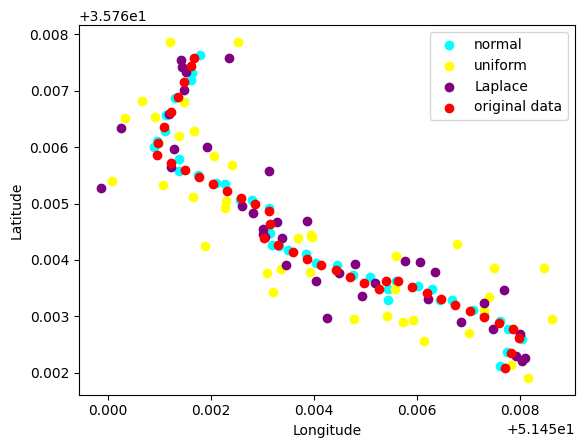

In [174]:
lat_normal, lon_normal = zip(*noisy_ride_normal)
lat_uniform, lon_uniform = zip(*noisy_ride_uniform)
lat_laplace, lon_laplace = zip(*noisy_ride_laplace)
lat_original, lon_original = zip(*ride)

plt.scatter(lon_normal, lat_normal, label='normal', color='cyan')
plt.scatter(lon_uniform, lat_uniform, label='uniform', color='yellow')
plt.scatter(lon_laplace, lat_laplace, label='Laplace', color='purple')
plt.scatter(lon_original, lat_original, label='original data', color='red')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()


In [175]:
ride_df = pd.DataFrame(ride, columns=['lat', 'lon'])
ride_nor_df = pd.DataFrame(noisy_ride_normal, columns=['lat', 'lon'])
map_ride_noise_normal = KeplerGl()
map_ride_noise_normal.add_data(data=ride_df, name='ride')
map_ride_noise_normal.add_data(data=ride_nor_df, name='normal')
map_ride_noise_normal

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

In [176]:
ride_uni_df = pd.DataFrame(noisy_ride_uniform, columns=['lat', 'lon'])
map_ride_noise_uniform = KeplerGl()
map_ride_noise_uniform.add_data(data=ride_df, name='ride')
map_ride_noise_uniform.add_data(data=ride_uni_df, name='uniform')
map_ride_noise_uniform

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

In [177]:
ride_exp_df = pd.DataFrame(noisy_ride_laplace, columns=['lat', 'lon'])
map_ride_noise_lap = KeplerGl()
map_ride_noise_lap.add_data(data=ride_df, name='ride')
map_ride_noise_lap.add_data(data=ride_exp_df, name='laplace')
map_ride_noise_lap

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

**Explanation of my noise model:**
بدیهی است که مدلی که نویز نرمال برای ما ایجاد میکند بهتر از دیگر مدل ها است چرا که همانطور که از توزیع نرمال مشخص است بیشتر داده ها به سمت میو میل میکند که یعنی داده ها به شکل منطقی ای نویز میگیرند و به صورت برابری احتمال دارد که اطراف واقعیت نمایش داده شوند و این یعنی تاثیر عوامل مختلف نویزی روی داده های ما به یک شکل است و اگر روی داده i ام نویز k را بیندازند به احتمال خوبی به داده j هم نویزی نزدیک k میدهد
...

Visualize a sample `ride` and its corresponding `noisy_ride` (using your selected noise model) on the map.

In [178]:
ride_df = pd.DataFrame(ride, columns=['lat', 'lon'])
ride_nor_df = pd.DataFrame(noisy_ride_normal, columns=['lat', 'lon'])
map_ride_noise_normal = KeplerGl()
map_ride_noise_normal.add_data(data=ride_df, name='ride')
map_ride_noise_normal.add_data(data=ride_nor_df, name='normal')
map_ride_noise_normal

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

Now, we create our dataset, We create 20 noisy_rides for each trip.

In [179]:
noisy_rides = []
for i in range(20):
    noisy_rides.append(apply_normal_noise(ride, 0.00008))
for noisy_ride in noisy_rides:
    for node in noisy_ride:
        print(node)
    print("------------------------")

[35.76196870123628, 51.45774008448948]
[35.76241879443058, 51.457784420421284]
[35.762575465368315, 51.45804720187166]
[35.762900001519654, 51.45775615719992]
[35.76278673224998, 51.457628252795345]
[35.76288985216508, 51.457350226306225]
[35.763076321338765, 51.457008461020536]
[35.76329644626628, 51.45678740993281]
[35.76332039728616, 51.45640259237187]
[35.763443655484934, 51.456103482618246]
[35.76352270045731, 51.45600387247221]
[35.763694660426886, 51.455693747957206]
[35.7636801746579, 51.455337890743486]
[35.7634560010441, 51.455242050250426]
[35.763516873079666, 51.455047070990304]
[35.763618635613106, 51.454862117923845]
[35.76361991022443, 51.45439878401427]
[35.763927954178506, 51.45401359645517]
[35.763915562117305, 51.45386685238106]
[35.76405674339158, 51.45358938613637]
[35.7641956650633, 51.45327740367317]
[35.764302361165406, 51.45300359683704]
[35.764808408102226, 51.45305060173895]
[35.7648519604818, 51.45301410980041]
[35.765053543253366, 51.45284239532571]
[35.764

# HMM

In this section, we want to use the dataset that we created in the previous section to train an HMM model. We want to use HMM models to  **denoise** the gps locations of the rides. We assume that the gps locations of the rides are noisy and we want to denoise them using HMM models. The observations in each _timestamp_ are the observed noisy points in the dataset.

You should implement a class (or function) named HMM which gets the noisy observations and the `streets` of the map (of course, this is not noisy. we saw that as `pasdaran_streets` in the previous section). You should calculate the transition matrix and emission matrix of the HMM model. You should also implement the `viterbi` algorithm to find the most probable sequence of hidden states (which are the points in the streets) given the noisy observations. Finally, your implementation should be capable of returning the denoised gps locations of the rides. Note that how you define your features, and your states. Be creative!

In [180]:
def project_and_distance_to_street(observation, street):
    start_point_lat, start_point_lon = street['u_lat'], street['u_lon']
    end_point_lat, end_point_lon = street['v_lat'], street['v_lon']
    one_lat = 40080000 / 360
    one_long = 40080000 * math.cos(start_point_lat) / 360
    street_vector = [(end_point_lat - start_point_lat) * one_lat, (end_point_lon - start_point_lon) * one_long]
    point_vector = [(observation[0] - start_point_lat) * one_lat, (observation[1] - start_point_lon) * one_long]
    line = Line.from_points(point_a=[0, 0], point_b=street_vector)
    projected_point = line.project_point(point_vector)
    projected_location = [start_point_lat + (projected_point[0] / one_lat), start_point_lon + (projected_point[1] / one_long)]
    mid_point = [(end_point_lat + start_point_lat) / 2, (end_point_lon + start_point_lon) / 2]
    distance_to_street = haversine(observation, mid_point) + (np.linalg.norm(np.cross(street_vector, point_vector)) / np.linalg.norm(street_vector)) / 1250
    return projected_location, distance_to_street


def transformation_coefficient(street, prev_street):
    street_start_lat, street_start_lon = street['u_lat'], street['u_lon']
    street_end_lat, street_end_lon = street['v_lat'], street['v_lon']
    prev_street_start_lat, prev_street_start_lon = prev_street['u_lat'], prev_street['u_lon']
    prev_street_end_lat, prev_street_end_lon = prev_street['v_lat'], prev_street['v_lon']
    one_lat = 40080000 / 360
    one_long = 40080000 * math.cos(street_start_lat) / 360
    street_mid_point = [((street_end_lat + street_start_lat) / 2) * one_lat, ((street_end_lon + street_start_lon) / 2) * one_long]
    prev_street_mid_point = [((prev_street_end_lat + prev_street_start_lat) / 2) * one_lat, ((prev_street_end_lon + prev_street_start_lon) / 2) * one_long]
    return 1000 / (((street_mid_point[0] / 2 - prev_street_mid_point[0]) ** 2 + (street_mid_point[1] / 2 - prev_street_mid_point[1]) ** 2) ** 0.5)

In [181]:
def find_best_paths(noisy_track, street_dataset):
    state_probabilities = [[[0.0, 0] for _ in range(6)] for _ in range(len(noisy_track))]
    best_previous_states = [[0 for _ in range(6)] for _ in range(len(noisy_track))]
    for t in range(len(noisy_track)):
        distances_tmp = []
        for s in range(len(street_dataset)):
            distances_tmp.append(project_and_distance_to_street(noisy_track[t], street_dataset.iloc[s])[1])
        args_sorted = np.argsort(distances_tmp)
        sum_of_distances = 0
        probabilities = []
        for x in range(6):
            tmp = 1 / (distances_tmp[args_sorted[x]])
            probabilities.append(tmp)
            sum_of_distances += tmp
        probabilities = [x / sum_of_distances for x in probabilities]
        for s in range(6):
            state_probabilities[t][s][1] = args_sorted[s]
            if t == 0:
                state_probabilities[t][s][0] = probabilities[s]
            else:
                best_previous_states[t][s] = max(range(6), key=lambda prev_s: state_probabilities[t-1][prev_s][0] * transformation_coefficient(street_dataset.iloc[state_probabilities[t][s][1]], street_dataset.iloc[state_probabilities[t][prev_s][1]]))
                max_prob = state_probabilities[t-1][best_previous_states[t][s]][0] * transformation_coefficient(street_dataset.iloc[state_probabilities[t][s][1]], street_dataset.iloc[state_probabilities[t][best_previous_states[t][s]][1]])
                state_probabilities[t][s][0] = max_prob * probabilities[s]
    best_path_pointer = max(range(6), key=lambda s: state_probabilities[-1][s][0])
    MLE_path = [project_and_distance_to_street(noisy_track[-1], street_dataset.iloc[state_probabilities[-1][best_path_pointer][1]])[0]]
    for t in range(len(noisy_track)-1, 0, -1):
        best_path_pointer = best_previous_states[t][best_path_pointer]
        MLE_path.insert(0, project_and_distance_to_street(noisy_track[t-1], street_dataset.iloc[state_probabilities[t-1][best_path_pointer][1]])[0])
    return MLE_path


Visualize a sample denoised _ride_ using your HMM model. Put `original_points` and `denoised_points` on the map. Use different colors for each of them to make them distinct from eachother. You should use `kepler` library for this purpose.

In [182]:
result_path = find_best_paths(noisy_rides[0], pasdaran_streets)
map_visualization = KeplerGl()
df_denoised_path = pd.DataFrame(result_path, columns=['lat', 'lon'])
df_noisy_track_0 = pd.DataFrame(noisy_rides[0], columns=['lat', 'lon'])
map_visualization.add_data(ride_df, 'ride')
map_visualization.add_data(df_noisy_track_0, 'noisy')
map_visualization.add_data(df_denoised_path, 'denoised')
map_visualization

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'ride': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21…

# Testing your model

In this section, you should test your model. You could use your dataset (which you generated, step-by-step) until now, to implement, debug and train your model. Now, you should load `test_dataset` that we provided to you as `noisy_test_dataset.csv` and `original_test_dataset.csv`. Run your model on `noisy_test_dataset` and use `original_test_dataset` to evaluate how good you did. run your model on `noisy_test_dataset` to denoise the points. You should put the denoised points in a csv file named `denoised_test_dataset.csv` and submit it with your notebook. Also, You should report the **Mean haversine distance (MHD)** as the measaure of the loss of your model. Go through each trip in the `noisy_test_dataset` and calculate the MHD for each trip. Finally, report the average of the MHDs of all the trips in the `test_dataset` as the MHD of your model.

In [145]:
def mean_haversine_distance(denoised_points, original_points):
    sum = 0
    for i in range(len(original_points) ):
      sum += haversine(original_points[i],denoised_points[i])
    return sum/len(original_points)
test_dataset_noisy = pd.read_csv("noisy_test_dataset.csv")
test_dataset_original = pd.read_csv("original_test_dataset.csv")
test_dataset_original.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771816,51.461178,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771458,51.460865,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770760,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.770027,51.459633,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769318,51.459030,0.00096,0.466


In [146]:
test_dataset_noisy.head()

,Unnamed: 0,trip_id,index,source,destination,lat,lon,ride_speed,ride_gps_time
0,0,0,0,4429680702,4695666788,35.771917,51.461279,0.00096,0.466
1,0,0,1,4429680702,4695666788,35.771399,51.460806,0.00096,0.466
2,0,0,2,4429680702,4695666788,35.770759,51.460239,0.00096,0.466
3,0,0,3,4429680702,4695666788,35.769997,51.459603,0.00096,0.466
4,0,0,4,4429680702,4695666788,35.769289,51.459002,0.00096,0.466


In [148]:
test_trips = []
ground_truth_paths = []
predicted_paths = []
total_haversine_distance = 0
num_valid_trips = 0
for trip_id in range(20):
    noisy_trip_data = test_dataset_noisy[test_dataset_noisy['trip_id'] == trip_id]
    test_trips.append(pd.DataFrame.to_numpy(noisy_trip_data[['lat', 'lon']]))
    original_trip_data = test_dataset_original[test_dataset_original['trip_id'] == trip_id]
    ground_truth_paths.append(pd.DataFrame.to_numpy(original_trip_data[['lat', 'lon']]))
    if len(test_trips[trip_id]) > 0:
        num_valid_trips += 1
        predicted_paths.append(find_best_paths(test_trips[trip_id], pasdaran_streets))
        haversine_distance = mean_haversine_distance(predicted_paths[trip_id], ground_truth_paths[trip_id])
        print(trip_id, haversine_distance)
        total_haversine_distance += haversine_distance
    else:
        predicted_paths.append(None)
denoised_data = []
for trip_id in range(20):
    if trip_id == 9:
        continue
    noisy_trip_data = test_dataset_noisy[test_dataset_noisy['trip_id'] == trip_id]
    test_array = pd.DataFrame.to_numpy(noisy_trip_data)
    for index, point in enumerate(predicted_paths[trip_id]):
        denoised_data.append([trip_id, index, test_array[0][3], test_array[0][4], point[0], point[1], test_array[0][7], test_array[0][8]])
denoised_df = pd.DataFrame(denoised_data, columns=['trip_id', 'index', 'source', 'destination', 'lat', 'lon', 'ride_speed', 'ride_gps_time'])
denoised_df.to_csv('denoised_test_dataset.csv', index=False)
average_haversine_distance = total_haversine_distance / num_valid_trips
print("Average Haversine Distance:", average_haversine_distance)

0 0.006185427520064381
1 0.010316079429544326
2 0.007998096765971529
3 0.011342894403639978
4 0.005677964746862704
5 0.009881695373194704
6 0.011872848298459908
7 0.00876277364534599
8 0.012064780069571337
10 0.003608047400582337
11 0.00816676238753283
12 0.010687324652116498
13 0.0037142048827620666
14 0.00594611951061969
15 0.00886839408539808
16 0.007863331284044577
17 0.011989317147662151
18 0.01035839613992782
19 0.010078831133168837
Average Haversine Distance: 0.008704383625077356


**How to submit**: You should submit your notebook and the `denoised_test_dataset.csv` file. Your codes are verified based on the "Mean haversine distance" value that your code gets and the `denoised_test_dataset.csv`. Also, note that for the **shortest path** section, you should have submitted the `.py` file, containing the `def find_shotest_path(start_node, end_node, graph)` function (and all of necessary imports) on quera. Your code will be verified based on the correctness of the shortest path that you find. So, you should submit these in total:
1. `STUDENT_NUMBER_Phase1.ipynb` or `.zip` file containing your notebook and the `denoised_test_dataset.csv` file.
2. `STUDENT_NUMBER_Phase1.py` file containing the `find_shortest_path` function. (Also submit this to the related section in quera)
3. Printed out Average Haversine Distance in the last cell of notebook. (This should be of order $10^{-3}$)